# Распознавание звука

## Импорт библиотек

In [231]:
import sys 
import os 

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import classification_report

import tensorflow as tf 
from tensorflow import keras
 
from IPython import display 

In [232]:
sys.path.append('D:/Programming/Python')

In [233]:
from tools import show_correlation, export2, rounding
from decorators import timeit
from ml_tools import training_plot, predictions_plot

# Импорт данных

In [189]:
os.listdir()

['commands',
 'commands_recognition.ipynb',
 '.git',
 'model_comands_classification.keras']

In [190]:
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory( 
    directory='commands', 
    batch_size=16, 
    validation_split=0.2, 
    output_sequence_length=16_000, 
    seed=0, 
    subset='both')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [191]:
label_names = training_set.class_names
print("label names:", label_names)

label names: ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']


In [192]:
audio, label = next(iter(training_set))

## Обработка данных

- Каждый файл WAV содержит данные временных рядов с заданным количеством выборок в секунду.
- Каждый образец представляет собой амплитуду звукового сигнала в это конкретное время.
- В 16-битной системе, такой как WAV-файлы в мини-наборе данных "Commands", значения амплитуд находятся в диапазоне от -32 768 до 32 767.
- Частота дискретизации для этого набора данных составляет 16 кГц.

In [193]:
def decode_audio(audio_binary):
  """Decode wav audio"""
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return audio

In [194]:
def squeeze(audio, labels): 
  '''transform to mono audio'''
  audio = tf.squeeze(audio, axis=-1) 
  return audio, labels 

In [195]:
training_set = training_set.map(squeeze, tf.data.AUTOTUNE) 
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [196]:
audio, label = next(iter(training_set))
audio[0]

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-3.0517578e-05,  3.0517578e-05,  3.0517578e-05, ...,
       -1.5258789e-04, -3.0517578e-05,  3.0517578e-05], dtype=float32)>

In [197]:
display.Audio(audio[0], rate=16_000)

## Визуализация

In [198]:
def plot_wave(waveform, label): 
    plt.figure(figsize=(10, 3)) 
    plt.title(label) 
    plt.plot(waveform) 
    plt.xlim([0, 16000]) 
    plt.ylim([-1, 1]) 
    plt.xlabel('Time') 
    plt.ylabel('Amplitude') 
    plt.grid(True) 
    plt.show()

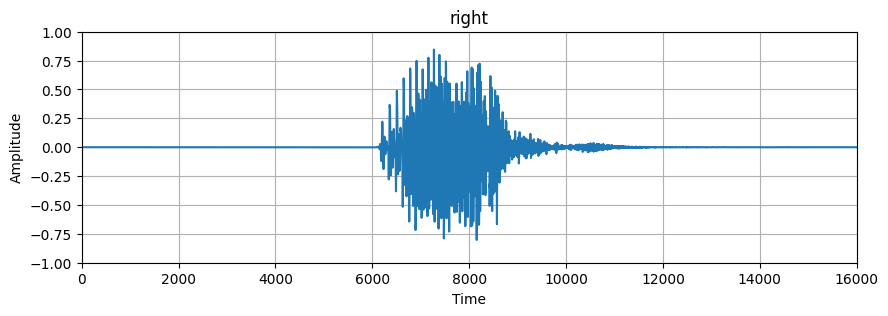

In [199]:
plot_wave(audio[0], label_names[label[0]]) 

In [200]:
def get_spectrogram(waveform): 
    '''Convert waveform to spectrogram'''
    # кратковременное преобразование Фурье STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128) 
    spectrogram = tf.abs(spectrogram) 
    return spectrogram[..., tf.newaxis] 

In [201]:
def plot_spectrogram(spectrogram, label): 
    spectrogram = np.squeeze(spectrogram, axis=-1) 
    log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
    plt.figure(figsize=(10, 3)) 
    plt.title(label) 
    plt.imshow(log_spec, aspect='auto', origin='lower') 
    plt.colorbar(format='%+2.0f dB') 
    plt.xlabel('Time') 
    plt.ylabel('Frequency') 
    plt.show()

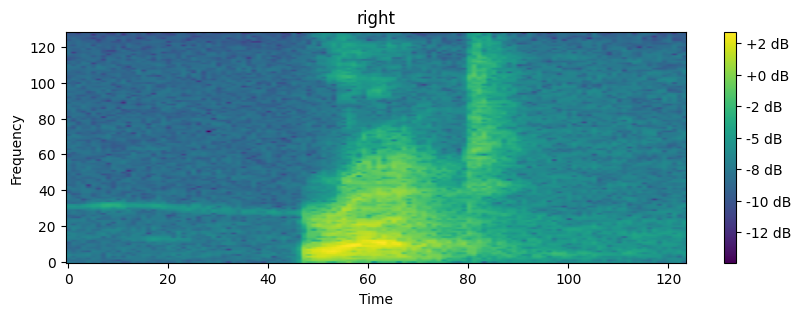

In [202]:
plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])

In [203]:
audio, label = next(iter(training_set))

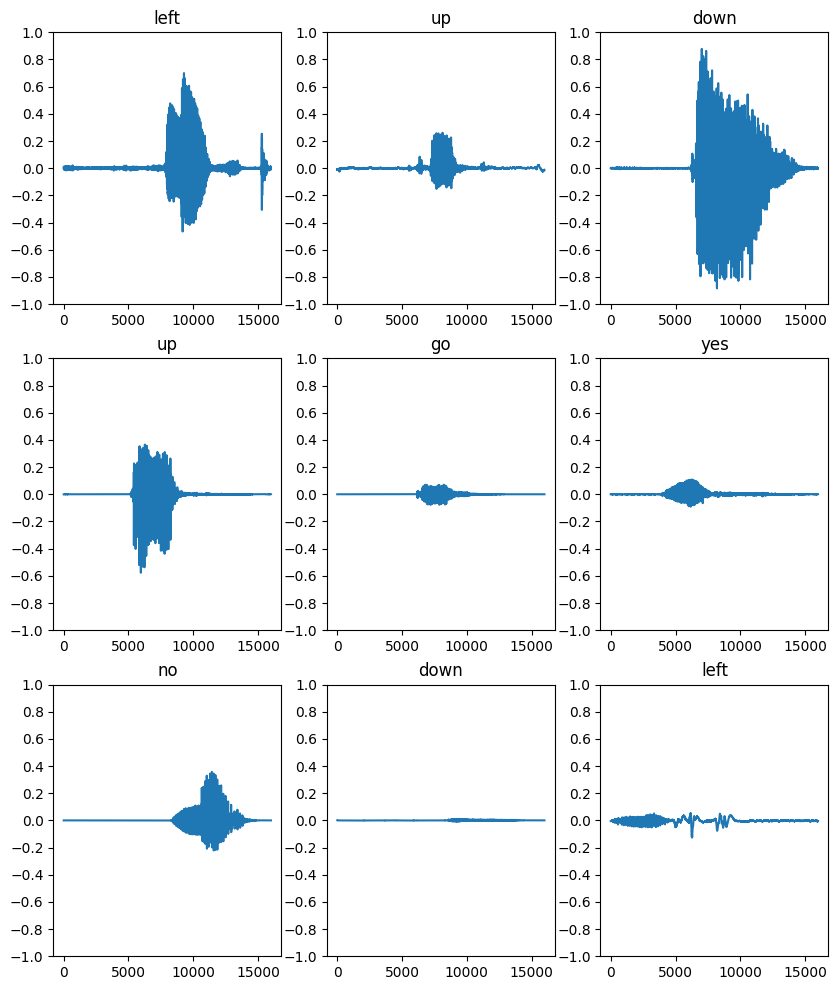

In [204]:
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(zip(audio, label)):
  if i == rows * cols: break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio)
  ax.set_yticks(np.linspace(-1, 1, 10+1))
  label = label_names[label]
  ax.set_title(label)

plt.show()

In [205]:
audio, label = next(iter(training_set))

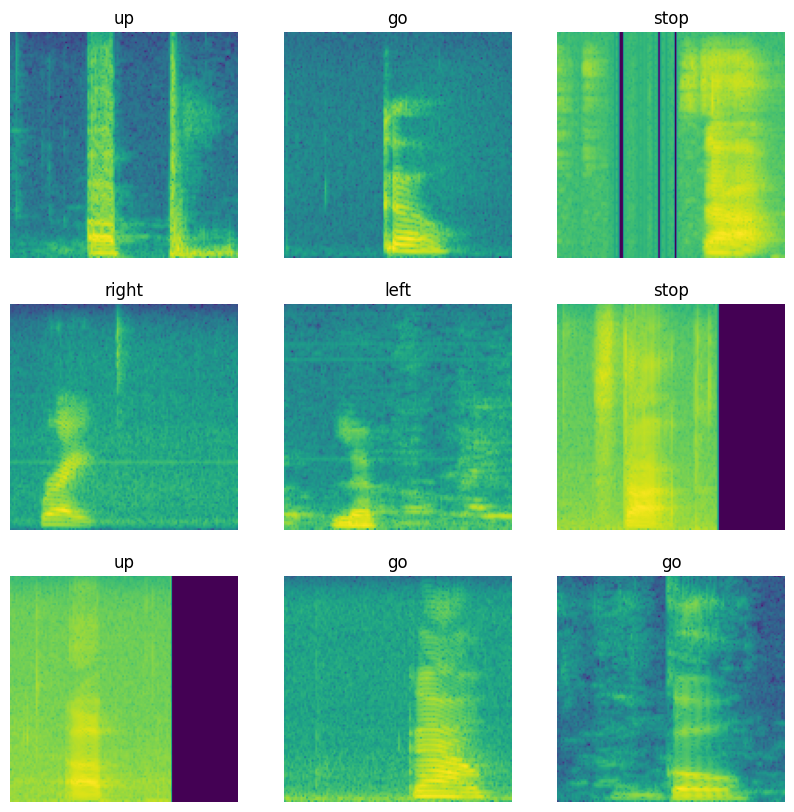

In [206]:
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (audio, label) in enumerate(zip(audio, label)):
    if i == rows * cols: break
    spectrogram = get_spectrogram(audio) 
    spectrogram = np.squeeze(spectrogram, axis=-1) 
    log_spec = np.log(spectrogram.T + np.finfo(float).eps) 
    r = i // cols
    c = i % cols  
    ax = axes[r][c]
    ax.imshow(log_spec, aspect='auto', origin='lower') 
    label = label_names[label]
    ax.set_title(label)
    ax.axis('off')

plt.show()

## Преобразование аудио в изображение спектограммы

In [207]:
def get_spectrogram_dataset(dataset): 
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), 
        num_parallel_calls=tf.data.AUTOTUNE) 
    return dataset

## Разделение данных

In [208]:
#train_text_split

train_set = get_spectrogram_dataset(training_set) 
validation_set = get_spectrogram_dataset(validation_set) 
  
val_set = validation_set.take(validation_set.cardinality() // 2) 
test_set = validation_set.skip(validation_set.cardinality() // 2)

Проврека размерности

In [209]:
train_set_shape = train_set.element_spec[0].shape 
val_set_shape = val_set.element_spec[0].shape 
test_set_shape = test_set.element_spec[0].shape 
  
print("Train set shape:", train_set_shape) 
print("Validation set shape:", val_set_shape) 
print("Testing set shape:", test_set_shape)

Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


## Построение модели

In [210]:
input_shape = next(iter(train_set))[0][0].shape 
print("Input shape:", input_shape) 
num_labels = len(label_names) 

Input shape: (124, 129, 1)


In [211]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.Resizing(64, 64))
model.add(tf.keras.layers.Normalization())

model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(num_labels, activation='softmax') )          

In [212]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 64, 64, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,568,011 (112.79 MB)

 Trainable params: 29,568,008 (112.79 MB)

 Non-trainable params: 3 (16.00 B)

In [218]:
model.compile( 
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'] 
) 

## Обучение модели

In [219]:
epochs = 10
verbose = True

monitor = 'loss'
min_delta = 0.01
patience = 5

callbacks = [keras.callbacks.EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose),
             keras.callbacks.ModelCheckpoint(monitor=monitor, filepath='checkpoints/model_{epoch:d}.keras', save_best_only=True, verbose=verbose)]

In [220]:
history = model.fit( 
    train_set, 
    validation_data=val_set, 
    epochs=epochs, 
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7:51 1s/step - accuracy: 0.7500 - loss: 0.572 ━━━━━━━━━━━━━━━━━━━━ 2:01 305ms/step - accuracy: 0.8125 - loss: 0.48 ━━━━━━━━━━━━━━━━━━━━ 1:50 279ms/step - accuracy: 0.8194 - loss: 0.47 ━━━━━━━━━━━━━━━━━━━━ 1:44 264ms/step - accuracy: 0.8294 - loss: 0.45 ━━━━━━━━━━━━━━━━━━━━ 1:41 258ms/step - accuracy: 0.8385 - loss: 0.44 ━━━━━━━━━━━━━━━━━━━━ 1:38 249ms/step - accuracy: 0.8446 - loss: 0.44 ━━━━━━━━━━━━━━━━━━━━ 1:36 245ms/step - accuracy: 0.8502 - loss: 0.43 ━━━━━━━━━━━━━━━━━━━━ 1:34 240ms/step - accuracy: 0.8543 - loss: 0.42 ━━━━━━━━━━━━━━━━━━━━ 1:32 236ms/step - accuracy: 0.8566 - loss: 0.42 ━━━━━━━━━━━━━━━━━━━━ 1:32 236ms/step - accuracy: 0.8578 - loss: 0.42 ━━━━━━━━━━━━━━━━━━━━ 1:31 234ms/step - accuracy: 0.8599 - loss: 0.41 ━━━━━━━━━━━━━━━━━━━━ 1:30 233ms/step - accuracy: 0.8620 - loss: 0.41 ━━━━━━━━━━━━━━━━━━━━ 1:30 234ms/step - accuracy: 0.8645 - loss: 0.40 ━━━━━━━━━━━━━━━━━━━━ 1:29 233ms/step - accuracy: 0.8659 - loss: 0.40 ━━━━━━━━━━━━━━━━━

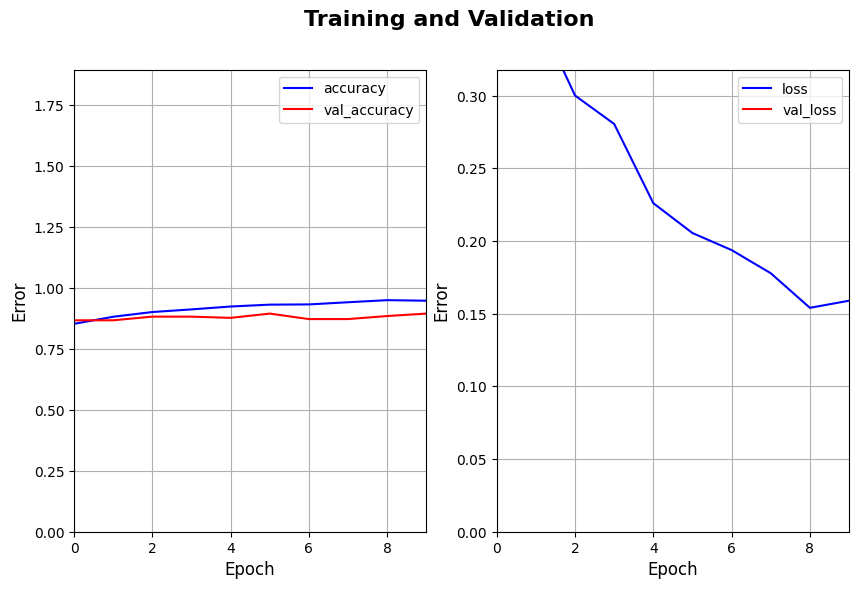

In [237]:
training_plot(history, figsize=(10, 6))

## Оценка модели

Матрица путаницы

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step  ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/ste ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


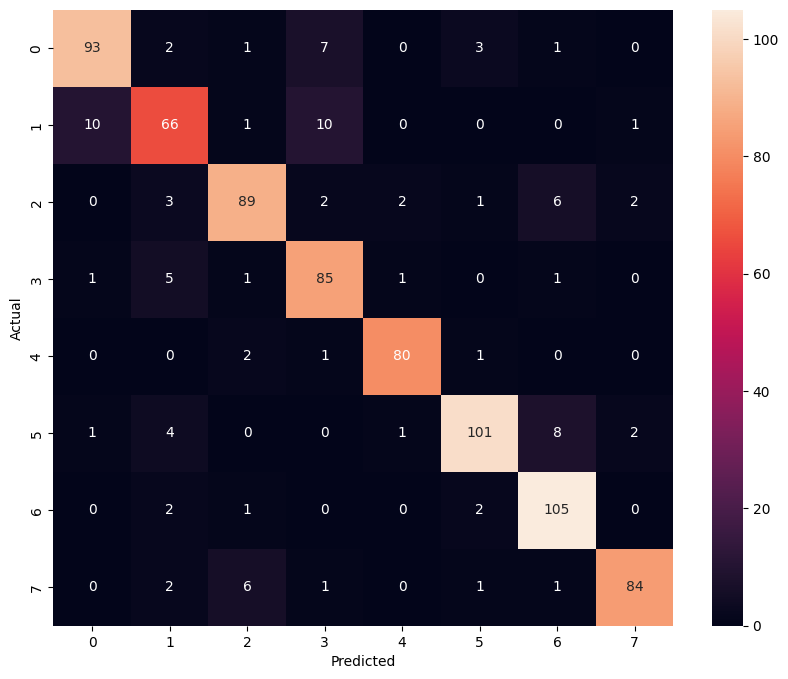

In [ ]:
y_pred = np.argmax(model.predict(test_set), axis=1) 
y_true = np.concatenate([y for x, y in test_set], axis=0) 
cm = tf.math.confusion_matrix(y_true, y_pred) 
  
# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

Классификационный отчет

In [ ]:
report = classification_report(y_true, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       107
           1       0.79      0.75      0.77        88
           2       0.88      0.85      0.86       105
           3       0.80      0.90      0.85        94
           4       0.95      0.95      0.95        84
           5       0.93      0.86      0.89       117
           6       0.86      0.95      0.91       110
           7       0.94      0.88      0.91        95

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



## Тестирование

In [ ]:
path = 'commands/yes/004ae714_nohash_0.wav'

In [ ]:
Input = tf.io.read_file(str(path)) 
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000) 
audio, labels = squeeze(x, 'yes')

In [ ]:
waveform = audio 
display.Audio(path)

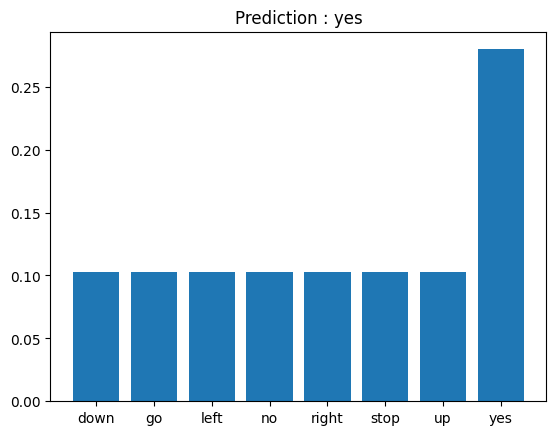

In [ ]:
x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 

prediction = model(x) 
plt.bar(label_names, tf.nn.softmax(prediction[0])) 
plt.title('Prediction: '+label_names[np.argmax(prediction, axis=1).item()]) 
plt.show()

In [ ]:
model.save('model_comands_classification.keras')